In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [1]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, IterableDataset
from tqdm import tqdm

In [2]:
os.chdir('..')
# os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [3]:
from fashion_recommendations.metrics.average_precision import mapk

In [4]:
pd.options.display.max_columns = None

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Load transactions

In [6]:
# ' '.join(transactions_train['article_id'].value_counts().head(12).index.tolist())

In [7]:
transactions_train = pd.read_csv('data/transactions_train.csv', dtype={'article_id': str})
print(transactions_train.shape)
transactions_train.head()

(31788324, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2


In [8]:
transactions_train['t_dat'] = pd.to_datetime(transactions_train['t_dat'])

In [9]:
transactions_train.groupby('customer_id')['article_id'].count().describe()

count    1.362281e+06
mean     2.333463e+01
std      3.924225e+01
min      1.000000e+00
25%      3.000000e+00
50%      9.000000e+00
75%      2.700000e+01
max      1.895000e+03
Name: article_id, dtype: float64

### Load articles

In [10]:
articles_df = pd.read_csv(
    'data/articles.csv', 
    dtype={'article_id': str},
    usecols=['article_id', 'garment_group_name', 'detail_desc']
)
print(articles_df.shape)
articles_df.head()

(105542, 3)


,article_id,garment_group_name,detail_desc
0,0108775015,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [11]:
articles_df.isnull().sum()

article_id              0
garment_group_name      0
detail_desc           416
dtype: int64

In [12]:
articles_df['detail_desc'] = np.where(
    articles_df['detail_desc'].isnull(), 
    articles_df['garment_group_name'], 
    articles_df['detail_desc']
)

### Find cut-offs

In [13]:
end = transactions_train['t_dat'].max()
endm1 = end - datetime.timedelta(days=7)
endm2 = endm1 - datetime.timedelta(days=7)
endm3 = endm2 - datetime.timedelta(days=7)

In [14]:
end, endm1, endm2, endm3

(Timestamp('2020-09-22 00:00:00'),
 Timestamp('2020-09-15 00:00:00'),
 Timestamp('2020-09-08 00:00:00'),
 Timestamp('2020-09-01 00:00:00'))

train
- inputs: start - endm3
- labels: emdm3 - endm2

dev
- inputs: start - endm2
- labels: emdm2 - endm1

test 
- inputs: start - endm1
- labels: endm1 - end

In [15]:
transactions_train = transactions_train.copy()[transactions_train['t_dat'] > '2020-05-01']

In [16]:
transactions_train['customer_id'].nunique()

665025

In [17]:
# % of items in last week which didn't appear in prior weeks' transactions
len(set(transactions_train[transactions_train['t_dat'] > endm1]['article_id']) - set(transactions_train[transactions_train['t_dat'] <= endm1]['article_id'])) / transactions_train[transactions_train['t_dat'] > endm1]['article_id'].nunique()

0.045813410430334704

In [18]:
transactions_train.shape

(6481103, 5)

In [19]:
transactions_train['article_id'].nunique() / articles_df.shape[0]

0.46167402550643344

### Filter out unnecessary articles

In [20]:
articles_df = articles_df.copy()[
    articles_df['article_id'].isin(transactions_train['article_id'].unique())
]

articles_df.reset_index(drop=True, inplace=True)
articles_df.drop(columns=['garment_group_name'], inplace=True)
print(articles_df.shape)
articles_df.head()

(48726, 2)


,article_id,detail_desc
0,0108775015,Jersey top with narrow shoulder straps.
1,0108775044,Jersey top with narrow shoulder straps.
2,0110065001,"Microfibre T-shirt bra with underwired, moulde..."
3,0110065002,"Microfibre T-shirt bra with underwired, moulde..."
4,0110065011,"Microfibre T-shirt bra with underwired, moulde..."


In [21]:
articles_df['article_id_idx'] = articles_df.index

In [22]:
article_id_to_idx = dict(zip(articles_df['article_id'], articles_df['article_id_idx']))

In [23]:
transactions_train['article_id_idx'] = transactions_train['article_id'].map(article_id_to_idx)
transactions_train['article_id_idx'] = transactions_train['article_id_idx'].astype(str)

### Create splits

#### Illustrative steps:

In [24]:
dev_labels = transactions_train.copy()[transactions_train['t_dat'] > endm1]

In [25]:
dev_inputs = transactions_train.copy()[transactions_train['t_dat'] <= endm1]

In [26]:
print(dev_inputs.shape)
dev_inputs.head()

(6240792, 6)


,t_dat,customer_id,article_id,price,sales_channel_id,article_id_idx
25307221,2020-05-02,0005c68366e7955683b7cdc75535f400d76c2e713b6277...,0608945019,0.016932,2,5619
25307222,2020-05-02,0005ef6698aeae9819c35dd1d63446f251797d07fe5b4a...,0808666003,0.059305,2,28271
25307223,2020-05-02,000ed4cabda96069b547ae531c66de5f1bf6a7e5b83aa8...,0743214005,0.011847,2,17660
25307224,2020-05-02,000ed4cabda96069b547ae531c66de5f1bf6a7e5b83aa8...,0804613005,0.042356,2,27200
25307225,2020-05-02,000ed4cabda96069b547ae531c66de5f1bf6a7e5b83aa8...,0804613005,0.042356,2,27200


In [48]:
dev_inputs.sort_values(['customer_id', 't_dat'], inplace=True)
dev_inputs.head()

,t_dat,customer_id,article_id,price,sales_channel_id,article_id_idx
31140481,2020-09-05,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043,0.050831,1,2964
28738780,2020-07-08,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0826211002,0.027102,1,24822
31521960,2020-09-15,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007,0.061000,2,19269
30223079,2020-08-12,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152002,0.027102,2,36886
30223080,2020-08-12,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050,0.033881,2,11614


In [49]:
# dev_inputs['total_purchases'] = dev_inputs.groupby('customer_id')['article_id'].transform('count')

In [50]:
# print(dev_inputs.shape)
# dev_inputs = dev_inputs.copy()[dev_inputs['total_purchases'] >= 10]
# print(dev_inputs.shape)

In [51]:
dev_inputs['article_id_idx'] = dev_inputs['article_id_idx'].astype(str)

- Age of last transaction
- Transaction count
- Incoporate count in vector representation

In [52]:
latest_transaction_date_by_cust = dev_inputs.groupby('customer_id')[['customer_id', 't_dat']].tail(1)
latest_transaction_date_by_cust.head()

,customer_id,t_dat
31140481,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2020-09-05
28738780,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2020-07-08
31521960,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2020-09-15
30223082,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2020-08-12
31492020,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,2020-09-14


In [53]:
dev_inputs = (
    dev_inputs
        .groupby('customer_id')
        .tail(10)  # Most recent articles only
        .groupby('customer_id')['article_id_idx']
        .apply(lambda x: ','.join(x))
        .reset_index()
)
print(dev_inputs.shape)
dev_inputs.head()

(463088, 2)


,customer_id,article_id_idx
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2964
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,24822
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,19269
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"36886,11614,39949,18973"
4,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,"10788,915"


In [54]:
dev_inputs = dev_inputs.merge(latest_transaction_date_by_cust.rename(columns={'t_dat': 't_dat_latest'}), on='customer_id')
print(dev_inputs.shape)
dev_inputs.head()

(463088, 3)


,customer_id,article_id_idx,t_dat_latest
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2964,2020-09-05
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,24822,2020-07-08
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,19269,2020-09-15
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"36886,11614,39949,18973",2020-08-12
4,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,"10788,915",2020-09-14


In [55]:
dev_labels.shape

(240311, 6)

In [56]:
dev_labels.head()

,t_dat,customer_id,article_id,price,sales_channel_id,article_id_idx
31548013,2020-09-16,000fb6e772c5d0023892065e659963da90b1866035558e...,0786022008,0.048441,2,18345
31548014,2020-09-16,000fb6e772c5d0023892065e659963da90b1866035558e...,0913272003,0.032288,2,38864
31548015,2020-09-16,000fb6e772c5d0023892065e659963da90b1866035558e...,0889669006,0.056508,2,35941
31548016,2020-09-16,0010e8eb18f131e724d6997909af0808adbba057529edb...,0237347060,0.033881,1,183
31548017,2020-09-16,0010e8eb18f131e724d6997909af0808adbba057529edb...,0562245001,0.013542,1,2689


In [69]:
num_purchases_df = dev_labels.groupby(['customer_id', 'article_id'])['t_dat'].count().reset_index().rename(columns={'t_dat': 'num_purchases'})
print(num_purchases_df.shape)
num_purchases_df.head()

(213728, 3)


,customer_id,article_id,num_purchases
0,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,0624486001,1
1,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0827487003,1
2,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,0640021019,1
3,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,0757926001,1
4,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,0788575004,1


In [78]:
num_purchases_df['num_purchases'] = num_purchases_df['num_purchases'].astype(str)

In [81]:
dev_labels = num_purchases_df.groupby('customer_id').agg(
    {
        'article_id': lambda x: ','.join(x),
        'num_purchases': lambda x: ','.join(x)
    }
).reset_index()

print(dev_labels.shape)
dev_labels.head()

(68984, 3)


,customer_id,article_id,num_purchases
0,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,0624486001,1
1,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0827487003,1
2,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,"0640021019,0757926001,0788575004","1,1,1"
3,000525e3fe01600d717da8423643a8303390a055c578ed...,0874110016,1
4,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,"0158340001,0448509014,0486639003,0799365027,08...","1,1,1,1,1,1,1,1,1,1,1,1,1,1"


In [82]:
dev_set = dev_inputs.merge(dev_labels, on='customer_id', how='outer', indicator=True, suffixes=('_last10', '_label'))
dev_set.shape

(484944, 6)

In [83]:
dev_set['_merge'].value_counts() / dev_set.shape[0]

left_only     0.857749
both          0.097182
right_only    0.045069
Name: _merge, dtype: float64

`left_only` = customers who did not make purchases in last week

`both` = customers who did make purchases in last week and made purchases in the past

`right_only` = customers who did make purchases in last week but made no purchases in the past (cold start)

Keep `both` only. For cold start we can just predict top-12 and `left_only` won't contribute to MAP

In [84]:
dev_set = dev_set.copy()[dev_set['_merge'] == 'both']
dev_set.drop('_merge', inplace=True, axis=1)
print(dev_set.shape)
dev_set.head()

(47128, 5)


,customer_id,article_id_idx,t_dat_latest,article_id,num_purchases
26,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,"39441,36213,38872,37897,38110,5642,4783,34346,...",2020-09-14,0827487003,1
33,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,"11936,16155,685,11824,2456,28519,11826,3269,23...",2020-09-09,"0640021019,0757926001,0788575004","1,1,1"
54,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,"35875,24399,21130,21130,21130,21130,40107,3128...",2020-09-12,"0158340001,0448509014,0486639003,0799365027,08...","1,1,1,1,1,1,1,1,1,1,1,1,1,1"
107,000fb6e772c5d0023892065e659963da90b1866035558e...,"24455,19793,37728,25547,35072,15616,39388,3938...",2020-09-10,"0786022008,0871519008,0889669006,0913272003,09...","1,3,2,2,1"
113,0010e8eb18f131e724d6997909af0808adbba057529edb...,"26967,15611,25069,34918,703",2020-08-25,"0237347060,0372860001,0456163060,0562245001,06...","1,1,1,1,1,1,1,1,1"


In [87]:
endm3

Timestamp('2020-09-01 00:00:00')

In [112]:
endm3 - datetime.timedelta(days=100)

Timestamp('2020-05-24 00:00:00')

In [113]:
dev_set['example_age'] = (endm3 - dev_set['t_dat_latest']).dt.days / 100

<AxesSubplot:>

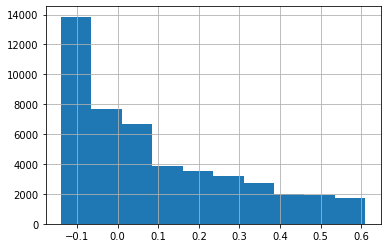

In [114]:
dev_set['example_age'].hist()

In [99]:
dev_set.head()

,customer_id,article_id_idx,t_dat_latest,article_id,num_purchases,example_age
26,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,"39441,36213,38872,37897,38110,5642,4783,34346,...",2020-09-14,0827487003,1,-13
33,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,"11936,16155,685,11824,2456,28519,11826,3269,23...",2020-09-09,"0640021019,0757926001,0788575004","1,1,1",-8
54,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,"35875,24399,21130,21130,21130,21130,40107,3128...",2020-09-12,"0158340001,0448509014,0486639003,0799365027,08...","1,1,1,1,1,1,1,1,1,1,1,1,1,1",-11
107,000fb6e772c5d0023892065e659963da90b1866035558e...,"24455,19793,37728,25547,35072,15616,39388,3938...",2020-09-10,"0786022008,0871519008,0889669006,0913272003,09...","1,3,2,2,1",-9
113,0010e8eb18f131e724d6997909af0808adbba057529edb...,"26967,15611,25069,34918,703",2020-08-25,"0237347060,0372860001,0456163060,0562245001,06...","1,1,1,1,1,1,1,1,1",7


#### Function

train
- inputs: start - endm3
- labels: emdm3 - endm2

dev
- inputs: start - endm2
- labels: emdm2 - endm1

test 
- inputs: start - endm1
- labels: endm1 - end

In [27]:
def create_article_input_output_df(inputs, labels, example_age_end, max_purchase_history=10):
    
    inputs = inputs.copy()
    labels = labels.copy()
    
    inputs.sort_values(['customer_id', 't_dat'], inplace=True)

    inputs['article_id_idx'] = inputs['article_id_idx'].astype(str)
    
    latest_transaction_date_by_cust = (
        inputs
            .groupby('customer_id')[['customer_id', 't_dat']]
            .tail(1)
    )
    
    inputs = (
        inputs
            .groupby('customer_id')
            .tail(max_purchase_history)  # Most recent articles only
            .groupby('customer_id')['article_id_idx']
            .apply(lambda x: ','.join(x))
            .reset_index()
    )
    
    inputs = inputs.merge(
        latest_transaction_date_by_cust.rename(columns={'t_dat': 't_dat_latest'}), 
        on='customer_id'
    )
    
    num_purchases_df = (
        labels
            .groupby(['customer_id', 'article_id_idx'])['t_dat']
            .count()
            .reset_index()
            .rename(columns={'t_dat': 'num_purchases'})
    )
    
    num_purchases_df['num_purchases'] = num_purchases_df['num_purchases'].astype(str)
    
    labels = num_purchases_df.groupby('customer_id').agg(
        {
            'article_id_idx': lambda x: ','.join(x),
            'num_purchases': lambda x: ','.join(x)
        }
    ).reset_index()

    data_set = inputs.merge(labels, on='customer_id', how='outer', indicator=True, suffixes=('_last10', '_label'))

    data_set = data_set.copy()[data_set['_merge'] == 'both']
    data_set.drop('_merge', inplace=True, axis=1)
    
    data_set['example_age'] = (example_age_end - data_set['t_dat_latest']).dt.days / 100

    return data_set

In [28]:
train_set = create_article_input_output_df(
    inputs=transactions_train.copy()[transactions_train['t_dat'] <= endm3], 
    labels=transactions_train.copy()[
        (transactions_train['t_dat'] > endm3) &
        (transactions_train['t_dat'] < endm2)
    ],
    example_age_end=endm3
)

print(train_set.shape)
train_set.head()

(52787, 6)


,customer_id,article_id_idx_last10,t_dat_latest,article_id_idx_label,num_purchases,example_age
16,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,21238,2020-07-21,10445,3,0.42
19,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,"47067,4125,39406,4130,47861,47698,22997,33621,...",2020-09-01,"4133,43785,46699,47830,48528","1,1,1,1,1",0.00
20,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,"37073,33658,28336,27815,30331",2020-08-07,30871,1,0.25
36,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,"16160,41543,24022,41131,41131,48130,47628,44359",2020-08-11,"46077,46294,47057","1,1,1",0.21
51,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,"42550,31027,32928,13993,37711,26267,42187,3305...",2020-07-12,"14131,20444,20448,27775,31005,45912,45914,46007","1,1,1,1,1,1,1,1",0.51


In [29]:
train_set['example_age'].min(), train_set['example_age'].max()

(0.0, 1.22)

In [30]:
dev_set = create_article_input_output_df(
    inputs=transactions_train.copy()[transactions_train['t_dat'] <= endm2], 
    labels=transactions_train.copy()[
        (transactions_train['t_dat'] > endm2) &
        (transactions_train['t_dat'] < endm1)
    ],
    example_age_end=endm3
)

print(dev_set.shape)
dev_set.head()

(52343, 6)


,customer_id,article_id_idx_last10,t_dat_latest,article_id_idx_label,num_purchases,example_age
20,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,"47698,22997,33621,47832,39261,4133,46699,47830...",2020-09-07,16299,1,-0.06
38,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,"41543,24022,41131,41131,48130,47628,44359,4705...",2020-09-05,"42436,43977,6392,7586","2,1,1,1",-0.04
45,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,"32778,43477,40051,38484,26244,33341,40891,4089...",2020-07-03,"16017,16018,16019,30046,3173,36210,4279,807","1,1,1,1,1,1,1,1",0.60
78,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,"46942,45237,27765,30317,44011,31540,27764,2776...",2020-07-25,"1234,39226,48295,48451","1,1,1,1",0.38
86,0008968c0d451dbc5a9968da03196fe20051965edde741...,"29216,35973,41328,4394,37472,40930,38237,23100...",2020-08-27,44654,1,0.05


In [31]:
dev_set['example_age'].min(), dev_set['example_age'].max()

(-0.07, 1.22)

In [32]:
test_set = create_article_input_output_df(
    inputs=transactions_train.copy()[transactions_train['t_dat'] <= endm1], 
    labels=transactions_train.copy()[
        (transactions_train['t_dat'] > endm1)
    ],
    example_age_end=endm3
)

print(test_set.shape)
test_set.head()

(54947, 6)


,customer_id,article_id_idx_last10,t_dat_latest,article_id_idx_label,num_purchases,example_age
40,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,"47628,44359,47057,46077,46294,7586,6392,42436,...",2020-09-14,32216,1,-0.13
48,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,"16160,21619,807,16017,3173,36210,16019,4279,30...",2020-09-09,"20199,24660,7590","1,1,1",-0.08
82,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,"44011,31540,27764,27764,27764,27764,48295,3922...",2020-09-12,"1102,1558,26347,39765,42252,44,46006,46423,472...","1,1,1,1,1,1,1,1,1,1,1,1,1,1",-0.11
157,000fb6e772c5d0023892065e659963da90b1866035558e...,"31611,26099,45907,32869,43183,20931,47575,4757...",2020-09-10,"24330,40688,44078,47049,47575","1,3,2,2,1",-0.09
165,0010e8eb18f131e724d6997909af0808adbba057529edb...,"38317,33880,30974,4037,3558,34488,20926,32318,...",2020-08-25,"1234,207,3494,45186,45690,47136,5740,5762,629","1,1,1,1,1,1,1,1,1",0.07


In [33]:
test_set['example_age'].min(), test_set['example_age'].max()

(-0.14, 1.22)

Inputs for submission:

In [34]:
submission_inputs = transactions_train.copy()

submission_inputs.sort_values(['customer_id', 't_dat'], inplace=True)

submission_inputs['article_id_idx'] = submission_inputs['article_id_idx'].astype(str)

latest_transaction_date_by_cust = (
    submission_inputs
        .groupby('customer_id')[['customer_id', 't_dat']]
        .tail(1)
)

submission_inputs = (
    submission_inputs
        .groupby('customer_id')
        .tail(10)  # Most recent articles only
        .groupby('customer_id')['article_id_idx']
        .apply(lambda x: ','.join(x))
        .reset_index()
)

submission_inputs = submission_inputs.merge(
    latest_transaction_date_by_cust.rename(columns={'t_dat': 't_dat_latest'}), 
    on='customer_id'
)

submission_inputs['example_age'] = (endm3 - submission_inputs['t_dat_latest']).dt.days / 100

In [35]:
submission_inputs.head()

,customer_id,article_id_idx,t_dat_latest,example_age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,3862,2020-09-05,-0.04
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,32040,2020-07-08,0.55
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,25450,2020-09-15,-0.14
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"4764,32303,30487,45052,15749,48137,25087",2020-08-12,0.20
4,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,"14660,1102",2020-09-14,-0.13


In [36]:
submission_inputs.rename(columns={'article_id_idx': 'article_id_idx_last10'}, inplace=True)
submission_inputs['article_id_idx_label'] = '0'
print(submission_inputs.shape)
submission_inputs.head()

(665025, 5)


,customer_id,article_id_idx_last10,t_dat_latest,example_age,article_id_idx_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,3862,2020-09-05,-0.04,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,32040,2020-07-08,0.55,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,25450,2020-09-15,-0.14,0
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"4764,32303,30487,45052,15749,48137,25087",2020-08-12,0.20,0
4,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,"14660,1102",2020-09-14,-0.13,0


In a given week what proportion of total customers make a purchase?

In [37]:
submission_inputs['num_purchases'] = '1'

In [38]:
all_customers = pd.read_csv('data/sample_submission.csv').shape[0]

In [39]:
submission_inputs.shape[0]

665025

In [40]:
print(dev_set['customer_id'].shape[0] / all_customers)
print(test_set['customer_id'].shape[0] / all_customers)

0.038151430778874326
0.04004941762999461


In [41]:
print(dev_set['customer_id'].shape[0] / submission_inputs.shape[0])
print(test_set['customer_id'].shape[0] / submission_inputs.shape[0])

0.07870831923611894
0.08262396150520657


Proportion of customers in dev/test sets who appear in training

In [42]:
dev_set[dev_set['customer_id'].isin(train_set['customer_id'])].shape[0] / dev_set.shape[0]

0.1954607110788453

In [43]:
test_set[test_set['customer_id'].isin(train_set['customer_id'])].shape[0] / dev_set.shape[0]

0.18594654490571805

Filter out customers who don't appear in training

In [44]:
dev_set = dev_set.copy()[dev_set['customer_id'].isin(train_set['customer_id'])]
test_set = test_set.copy()[test_set['customer_id'].isin(train_set['customer_id'])]

In [45]:
train_set.shape

(52787, 6)

In [46]:
dev_set.shape

(10231, 6)

In [47]:
test_set.shape

(9733, 6)

### Filter customers and get customer features

In [48]:
customers = pd.read_csv('data/customers.csv', usecols=['customer_id', 'FN', 'Active', 'age'])
print(customers.shape)
customers.head()

(1371980, 4)


,customer_id,FN,Active,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,24.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,54.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,52.0


In [49]:
customers_to_keep = set(train_set['customer_id'])
len(customers_to_keep)

52787

Filter out other customers from submission inputs (for other customers we'll just predict top-12)

In [50]:
len(customers_to_keep) / len(submission_inputs)

0.07937596330965001

In [51]:
submission_inputs = submission_inputs.copy()[submission_inputs['customer_id'].isin(customers_to_keep)]
submission_inputs.shape

(52787, 6)

In [52]:
customers = customers.copy()[customers['customer_id'].isin(customers_to_keep)]
customers.reset_index(drop=True, inplace=True)
customers.head()

,customer_id,FN,Active,age
0,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,NaN,NaN,45.0
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,1.0,1.0,44.0
2,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,NaN,NaN,21.0
3,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,33.0
4,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,NaN,NaN,21.0


In [53]:
customers.isnull().sum() / customers.shape[0]

customer_id    0.000000
FN             0.522667
Active         0.529543
age            0.003486
dtype: float64

In [54]:
customers[['FN', 'Active']] = customers[['FN', 'Active']].fillna(0)

Despite potential data leakage we impute the nulls for age here:

In [55]:
customers.shape

(52787, 4)

In [56]:
from sklearn.impute import SimpleImputer

In [57]:
simple_imputer = SimpleImputer()

In [58]:
customers[['age']] = simple_imputer.fit_transform(customers[['age']])

In [59]:
customers['age'] /= 100

In [60]:
customers.isnull().sum() / customers.shape[0]

customer_id    0.0
FN             0.0
Active         0.0
age            0.0
dtype: float64

In [61]:
customers['customer_id_idx'] = customers.index

In [62]:
customers.head()

,customer_id,FN,Active,age,customer_id_idx
0,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0.0,0.0,0.45,0
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,1.0,1.0,0.44,1
2,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0.0,0.0,0.21,2
3,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,0.33,3
4,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,0.0,0.0,0.21,4


In [63]:
train_set = train_set.merge(customers, on=['customer_id'])
dev_set = dev_set.merge(customers, on=['customer_id'])
test_set = test_set.merge(customers, on=['customer_id'])

In [64]:
submission_inputs = submission_inputs.merge(customers, on=['customer_id'])

In [65]:
train_set.head()

,customer_id,article_id_idx_last10,t_dat_latest,article_id_idx_label,num_purchases,example_age,FN,Active,age,customer_id_idx
0,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,21238,2020-07-21,10445,3,0.42,0.0,0.0,0.45,0
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,"47067,4125,39406,4130,47861,47698,22997,33621,...",2020-09-01,"4133,43785,46699,47830,48528","1,1,1,1,1",0.00,1.0,1.0,0.44,1
2,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,"37073,33658,28336,27815,30331",2020-08-07,30871,1,0.25,0.0,0.0,0.21,2
3,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,"16160,41543,24022,41131,41131,48130,47628,44359",2020-08-11,"46077,46294,47057","1,1,1",0.21,1.0,1.0,0.33,3
4,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,"42550,31027,32928,13993,37711,26267,42187,3305...",2020-07-12,"14131,20444,20448,27775,31005,45912,45914,46007","1,1,1,1,1,1,1,1",0.51,0.0,0.0,0.21,4


In [66]:
train_set = train_set[['customer_id_idx', 'article_id_idx_last10', 'article_id_idx_label', 'FN', 'Active', 'age', 'num_purchases', 'example_age']]
dev_set = dev_set[['customer_id_idx', 'article_id_idx_last10', 'article_id_idx_label', 'FN', 'Active', 'age', 'num_purchases', 'example_age']]
test_set = test_set[['customer_id_idx', 'article_id_idx_last10', 'article_id_idx_label', 'FN', 'Active', 'age', 'num_purchases', 'example_age']]

In [67]:
submission_inputs = submission_inputs[['customer_id_idx', 'article_id_idx_last10', 'article_id_idx_label', 'FN', 'Active', 'age', 'num_purchases', 'example_age']]

In [68]:
train_set.head()

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,num_purchases,example_age
0,0,21238,10445,0.0,0.0,0.45,3,0.42
1,1,"47067,4125,39406,4130,47861,47698,22997,33621,...","4133,43785,46699,47830,48528",1.0,1.0,0.44,"1,1,1,1,1",0.00
2,2,"37073,33658,28336,27815,30331",30871,0.0,0.0,0.21,1,0.25
3,3,"16160,41543,24022,41131,41131,48130,47628,44359","46077,46294,47057",1.0,1.0,0.33,"1,1,1",0.21
4,4,"42550,31027,32928,13993,37711,26267,42187,3305...","14131,20444,20448,27775,31005,45912,45914,46007",0.0,0.0,0.21,"1,1,1,1,1,1,1,1",0.51


In [69]:
dev_set.head()

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,num_purchases,example_age
0,1,"47698,22997,33621,47832,39261,4133,46699,47830...",16299,1.0,1.0,0.44,1,-0.06
1,3,"41543,24022,41131,41131,48130,47628,44359,4705...","42436,43977,6392,7586",1.0,1.0,0.33,"2,1,1,1",-0.04
2,13,"33575,39811,39811,39811,40861,42452,26645,1042...","18461,20230,20812,26646,26652,42288",0.0,0.0,0.41,"1,1,1,1,1,2",-0.03
3,15,"47257,45038,46660,45634,35543,5815,31611,26099...","20931,43183,47575,48163",1.0,1.0,0.42,"1,1,2,2",-0.05
4,17,"3659,21195,36713,20502,2893,2895,30391,48452,4...","44663,46496",1.0,1.0,0.23,"1,1",-0.07


In [70]:
submission_inputs.head()

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,num_purchases,example_age
0,0,"21238,10445,10445,10445",0,0.0,0.0,0.45,1,-0.03
1,1,"22997,33621,47832,39261,4133,46699,47830,48528...",0,1.0,1.0,0.44,1,-0.13
2,2,"37073,33658,28336,27815,30331,30871",0,0.0,0.0,0.21,1,-0.01
3,3,"44359,47057,46077,46294,7586,6392,42436,42436,...",0,1.0,1.0,0.33,1,-0.21
4,4,"28220,39016,31005,20448,27775,45912,14131,4600...",0,0.0,0.0,0.21,1,-0.02


### Save files

In [71]:
train_set.to_csv('data/final_train_set_with_counts_and_age_extended.tsv', sep='\t', index=False)
dev_set.to_csv('data/final_dev_set_with_counts_and_age_extended.tsv', sep='\t', index=False)
test_set.to_csv('data/final_test_set_with_counts_and_age_extended.tsv', sep='\t', index=False)
submission_inputs.to_csv('data/final_submission_inputs_with_counts_and_age_extended.tsv', sep='\t', index=False)

articles_df.to_csv('data/articles_df_filt_with_counts_and_age_extended.csv', index=False)
customers.to_csv('data/customers_filt_with_counts_and_age_extended.csv', index=False)

### IterableDataset

In [70]:
class RecommendationDatasetMultiLabel(IterableDataset):

    def __init__(self, dataset_filepath, article_emb_bag, total_articles):
        
        self.dataset_itr = open(dataset_filepath, 'r')
        next(self.dataset_itr)  # skip header
        
        self.article_emb_bag = article_emb_bag
        
        self.total_articles = total_articles
    
    def process_label(self, label_str: str, num_purchases_str: str):
        
        labels = torch.tensor([int(v) for v in label_str.split(',')])
        
        num_purchases = torch.tensor([float(v) for v in num_purchases_str.split(',')])
        
        target = torch.zeros(self.total_articles).scatter_(0, labels, num_purchases)

        return target
    
    def mean_historical_purchases_embedding(self, input_str: str):
        
        indices = torch.tensor([int(v) for v in input_str.split(',')])

        mean_emb = self.article_emb_bag(indices.unsqueeze(0)).flatten()
            
        return mean_emb
    
    def process_numeric_features(self, fn: str, active: str, age: str, example_age: str):
        numeric_features_tensor = torch.tensor([
            float(fn),
            float(active),
            float(age),
            float(example_age)
        ])

        return numeric_features_tensor
    
    def parse_itr(self, dataset_itr):
        
        for line in dataset_itr:
        
            line_items = line.rstrip('\n').split('\t')
            
            customer_id_idx, article_id_idx_last10, article_id_idx_label, fn, active, age, num_purchases, example_age = line_items
            
            customer_id_idx = int(customer_id_idx)
            
            numeric_features_tensor = self.process_numeric_features(fn, active, age, example_age)
            
            mean_emb = self.mean_historical_purchases_embedding(article_id_idx_last10)

            label = self.process_label(article_id_idx_label, num_purchases)    
            
            inputs = torch.concat((mean_emb, numeric_features_tensor))

            yield customer_id_idx, inputs, label
        
    def get_stream(self, dataset_itr):
        
        return self.parse_itr(dataset_itr)

    def __iter__(self):
        
        return self.get_stream(self.dataset_itr)

In [81]:
dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_with_counts_and_age.tsv', article_emb_bag=article_emb_bag, total_articles=total_articles)

In [84]:
pd.read_csv('data/final_train_set_with_counts_and_age.tsv', sep='\t').head(20)

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,num_purchases,example_age
0,0,15861,7705,0.0,0.0,0.45,3,0.42
1,1,"38882,3152,31459,3157,39673,39510,17255,26222,...","3160,35654,38515,39642,40340",1.0,1.0,0.44,"1,1,1,1,1",0.00
2,2,"21627,21175,23351",23816,0.0,0.0,0.21,1,0.25
3,3,"18099,33097,33097,39942,39441,36213","37897,38110,38872",1.0,1.0,0.33,"1,1,1",0.21
4,4,"23950,25602,10293,29865,19920,34107,25721,2152...","10396,15220,15224,21141,23930,37733,37735,37827",0.0,0.0,0.21,"1,1,1,1,1,1,1,1",0.51
5,5,"23368,29644,546,7957","23326,34657,34797,37783",0.0,0.0,0.19,"2,1,1,1",0.32
6,6,"32407,33337,34491,34150,39072,14076,14074,2120...","39072,40138",0.0,0.0,0.36,"1,1",0.02
7,7,"4388,37067,32054,30795,33397,15496,26253,1059,...","24455,30121",0.0,0.0,0.40,"1,1",0.19
8,8,"21970,10865","2471,35881,37827",1.0,1.0,0.22,"1,1,1",0.50
9,9,"25681,24592,30530,2370","23806,30609,37567",1.0,1.0,0.59,"1,1,1",0.35


In [83]:
train_loader = DataLoader(dataset, batch_size=4)  
    
for idx, data in enumerate(train_loader):
    
    if idx == 5:
        break
    else:
        customer_id_idx, inputs, label = data
        print(customer_id_idx)
        print(inputs)
        print(label)
        print(label.max(dim=1))
        print('\n')

tensor([0, 1, 2, 3])
tensor([[-1.2173,  0.1219, -0.2311,  ...,  0.0000,  0.4500,  0.4200],
        [-0.1295, -0.0226,  0.2097,  ...,  1.0000,  0.4400,  0.0000],
        [ 0.0787, -0.0579,  0.0796,  ...,  0.0000,  0.2100,  0.2500],
        [ 0.2321,  0.9143, -1.3484,  ...,  1.0000,  0.3300,  0.2100]],
       grad_fn=<StackBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.return_types.max(
values=tensor([3., 1., 1., 1.]),
indices=tensor([ 7705,  3160, 23816, 37897]))


tensor([4, 5, 6, 7])
tensor([[ 0.4209,  0.1502,  0.3306,  ...,  0.0000,  0.2100,  0.5100],
        [ 0.3754, -0.4886, -0.1319,  ...,  0.0000,  0.1900,  0.3200],
        [-0.6902,  0.3733, -0.0310,  ...,  0.0000,  0.3600,  0.0200],
        [-0.5472,  0.3336,  0.1550,  ...,  0.0000,  0.4000,  0.1900]],
       grad_fn=<StackBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..

torch.return_types.max(
values=tensor([1., 1., 1., 1.]),
indices=tensor([ 1355, 23407, 37585, 18835]))

### TODO

- Wrap processing steps in a function and apply to train, test sets  [DONE]
- Add customer features here (FN, Active, Age)  [DONE]
- Save sets as CSVs  [DONE]
- Save reduced articles df - use to generate correct embeddings by index  [DONE]
- Save customers df - use to generate correct embeddings by index  [DONE]
- Write iterable dataset which processes dataset  [DONE]
    - Get mean for each of inputs and take average to use as input
    - Multi-hot encode label

Checks of proecessing steps:

Multi-hot encoding:

https://discuss.pytorch.org/t/what-kind-of-loss-is-better-to-use-in-multilabel-classification/32203/3

In [101]:
article_id_idx_label = dev_set.iloc[3]['article_id_idx_label']
article_id_idx_label

'18345,38864,35941,32663,39388'

In [72]:
total_articles = articles_df.shape[0]

In [112]:
labels = torch.tensor([int(v) for v in article_id_idx_label.split(',')])
labels

tensor([18345, 38864, 35941, 32663, 39388])

In [111]:
target = torch.zeros(total_articles).scatter_(0, labels, 1.)
target

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [114]:
target[labels]

tensor([1., 1., 1., 1., 1.])

In [115]:
target.sum()

tensor(5.)

Getting mean encoding of historical basket

In [73]:
article_emb_bag = nn.EmbeddingBag(num_embeddings=total_articles, embedding_dim=384)

In [135]:
article_id_idx_last10 = dev_set.iloc[5]['article_id_idx_last10']
article_id_idx_last10

'37757,34393,5646,38997'

In [136]:
indices = torch.tensor([int(v) for v in article_id_idx_last10.split(',')])
indices

tensor([37757, 34393,  5646, 38997])

In [137]:
indices.unsqueeze(0)

tensor([[37757, 34393,  5646, 38997]])

In [138]:
mean_emb = article_emb_bag(indices.unsqueeze(0))
mean_emb.shape

torch.Size([1, 384])

In [139]:
torch.testing.assert_allclose(
    mean_emb.flatten(),
    article_emb_bag.weight[indices].mean(dim=0)
)

In [141]:
mean_emb = article_emb_bag(indices, offsets=torch.tensor([0]))
mean_emb.shape

torch.Size([1, 384])

In [142]:
torch.testing.assert_allclose(
    mean_emb.flatten(),
    article_emb_bag.weight[indices].mean(dim=0)
)